# Multivariate time-series classification using GPSig

In this notebook, we will train an SVGP classifier on the UWaveGestureLibraryAll dataset, which contains 896 train and 3582 test time-series of length 315 and dimension 3, showing one of 8 motion types. We will use only 200 inducing tensors for summarizing the time-series in the training set, and get a good result on the test set. The dataset is available from http://www.timeseriesclassification.com.

In [1]:
import sys
sys.path.append('..')

import numpy as np # for manipulating numerical arrays
import tensorflow as tf # base deep learning framework for training models
import gpflow as gp # gp framework we build on
import gpsig # gps with signature covariances
import pickle # saving to and loading data from disk
from scipy.io import arff # loading arff files
import matplotlib.pyplot as plt # plotting
plt.style.use('seaborn-darkgrid') # for prettier plots

***
Dataset is available at: http://www.timeseriesclassification.com/Downloads/UWaveGestureLibraryAll.zip. We will use the following files from the archive

In [2]:
train_file = './UWaveGestureLibraryAll/UWaveGestureLibraryAll_TRAIN.arff'
test_file = './UWaveGestureLibraryAll/UWaveGestureLibraryAll_TEST.arff'
num_features = 3

We load the data from the disk

In [3]:
train_data = arff.loadarff(train_file)
test_data = arff.loadarff(test_file)

And extract the input data into (num_examples, stream_length, num_features) format and the targets into (num_examples,) format

In [4]:
X_train = np.stack([np.asarray(list(x), dtype=np.float64)[:-1].reshape([num_features, -1]).transpose() for x in train_data[0]])
y_train = np.stack([int(x[-1]) for x in train_data[0]])
X_test = np.stack([np.asarray(list(x), dtype=np.float64)[:-1].reshape([num_features, -1]).transpose() for x in test_data[0]])
y_test = np.stack([int(x[-1]) for x in test_data[0]])

***
We inspect the target labels:

In [5]:
np.unique(y_train)

array([1, 2, 3, 4, 5, 6, 7, 8])

... the labels are indexed from 1, but for the GPflow MultiClass likelihood they must start from 0, so we take care of this.

In [6]:
y_train -= 1
y_test -= 1
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7])

***
Now, we perform a train-val split on the current training data to be able to monitor the generalization error during optimization:

In [7]:
X_train.shape

(896, 315, 3)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.15, stratify=y_train)

In [9]:
print('train shape: {}'.format(X_train.shape))
print('val shape: {}'.format(X_val.shape))
print('test shape: {}'.format(X_test.shape))

train shape: (761, 315, 3)
val shape: (135, 315, 3)
test shape: (3582, 315, 3)


***
We inspect some examples from the train data

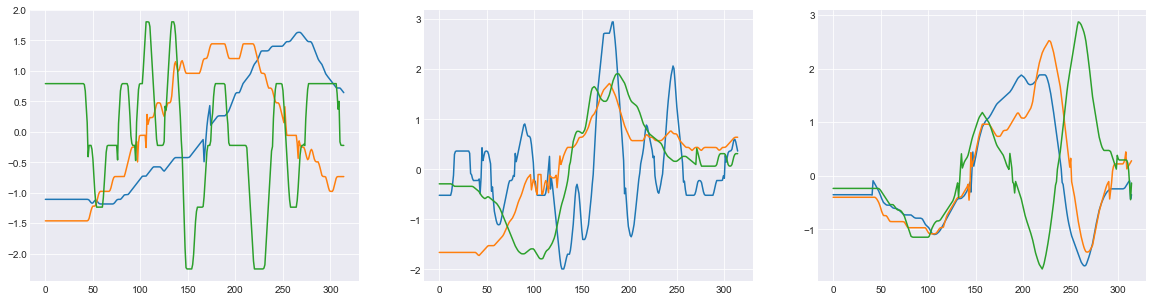

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(X_train[0])
axes[1].plot(X_train[50])
axes[2].plot(X_train[500])

... and add time (a uniformly increasing coordinate from 0 to 1) as the first dimension to each example

In [11]:
X_train = gpsig.preprocessing.add_time_to_table(X_train, num_features=num_features)
X_val = gpsig.preprocessing.add_time_to_table(X_val, num_features=num_features)
X_test = gpsig.preprocessing.add_time_to_table(X_test, num_features=num_features)
num_features += 1

Also, all coordinates seem to move on the same scales, but we may still choose to z-normalize each stream dimension-by-dimension. This type of normalization makes particular sense for motion recognition data, that we are working with, to neutralize against scale and offset differences across realizations of the same motion.

In [12]:
from sklearn.preprocessing import StandardScaler
X_train = np.asarray([StandardScaler().fit_transform(x) for x in X_train])
X_val = np.asarray([StandardScaler().fit_transform(x) for x in X_val])
X_test = np.asarray([StandardScaler().fit_transform(x) for x in X_test])

and we plot the data again:

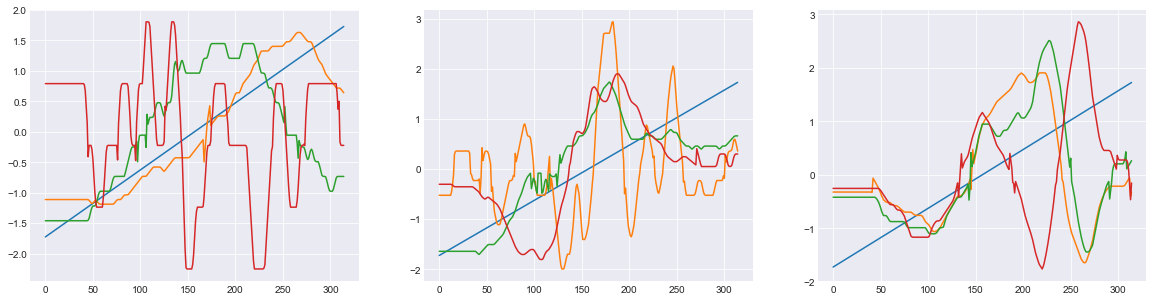

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(X_train[0])
axes[1].plot(X_train[50])
axes[2].plot(X_train[500])

***
Now, we initialize the model. For faster training time, we will only use 3 levels in the signature, which is also usually sufficient for the SequentialRBF kernel, but sometimes not for the SequentialLinear kernel.

In [14]:
num_levels = 3
num_train, stream_length, num_features = X_train.shape
num_val = X_val.shape[0]
num_test = X_test.shape[0]
num_classes = np.unique(y_train).size
input_dim = stream_length * num_features

In [15]:
# reshaping data into 2d format
X_train = X_train.reshape([num_train, -1])
X_val = X_val.reshape([num_val, -1])
X_test = X_test.reshape([num_test, -1])

We must set some initial values for the inducing tensors, for which we choose randomly sampled observations from the training dataset, tiled along each axis of the tensor.

In [16]:
# randomly initialize inducing inputs from the data
num_inducing = 200
samples_train = X_train.reshape([-1, num_features])
Z = samples_train[np.random.choice(stream_length*num_train, size=(num_inducing), replace=False)] # choose num_inducing samples from all observations of the training set
Z = np.tile(Z[None, ...], [int(num_levels*(num_levels+1)/2), 1, 1]) # tile the selected samples along all axes of the tensors
Z += np.random.randn(num_inducing, num_features) * 0.2 # slightly perturb all tensor inputs 

Here we define the kernel and the model.

For kernel, we use *gpsig.kernels.SequentialRBF*, that has 3 mandatory parameters:
- input_dim - defining the total width of the 2d input array, i.e. stream_length * num_features
- num_levels - the number of levels to compute in the signature kernel
- num_features - the dimension of the input streams
and an optional parameter, that we use:
- ARD - a boolean indicating whether to have one lengthscale parameter for each stream coordinate and one variance parameter for each level in the signature kernel

The model we use is *gpsig.models.SeqIDSVGP*, referring to Sequentialized Inter-Domain Sparse Variational GP. Its parameters are:
- X_train, y_train - the training inputs and targets
- likelihood - a GPflow likelihood object that we use to model the data
- kern - a sequentialized kernel object from *gpsig.kernels*
- num_latent - the dimensionality of the latent space, in the case of MultiClass equal to num_classes
- Z - the initial values of the inducing tensors, must be of shape (num_inducing, num_levels*(num_levels+1)/2, num_features)
- minibatch_size - the size of the batches while training

In [17]:
# initialize the model
minibatch_size = 50 # use a minibatch_size of 50 while optimizing
seq_k = gpsig.kernels.SequentialRBF(input_dim, ARD=True, num_levels=num_levels, num_features=num_features)
m = gpsig.models.SeqIDSVGP(X_train, y_train, likelihood=gp.likelihoods.MultiClass(num_classes=num_classes), kern=seq_k, num_latent=num_classes, Z=Z, minibatch_size=minibatch_size)

Define a function for monitoring validation error:

In [18]:
from sklearn.metrics import accuracy_score
val_scorer = lambda m: accuracy_score(y_val, np.argmax(m.predict_y(X_val)[0], axis=1))

We inspect the parameters of the model:

In [19]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SeqIDSVGP/kern/gamma,Parameter,None,+ve,True,(),True,0.25
SeqIDSVGP/kern/lengthscales,Parameter,None,+ve,True,"(4,)",True,"[1.0, 1.0, 1.0, 1.0]"
SeqIDSVGP/kern/variances,Parameter,None,+ve,True,"(4,)",True,"[0.5, 1.0, 1.0, 1.0]"
SeqIDSVGP/likelihood/invlink/epsilon,Parameter,"Beta(0.2,5.0)","[0.0, 1.0]",False,(),True,0.001
SeqIDSVGP/q_mu,Parameter,None,(none),True,"(200, 8)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0...."
SeqIDSVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(8, 200, 200)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
SeqIDSVGP/seq_Z,Parameter,None,(none),True,"(6, 200, 4)",True,"[[[-1.7995499862987594, -1.1812370982308655, -..."
SeqIDSVGP/white,Parameter,None,+ve,True,(),True,0.05


Setting up the optimization procedure:

In [20]:
opt = gpsig.optimizers.NadamOptimizer # use NadamOptimizer
global_step = tf.train.get_or_create_global_step(graph=m.enquire_graph()) # initialize a global step parameter
m.enquire_session().run(global_step.initializer)

In [21]:
m.kern.set_trainable(False) # fix kernel parameters
m.white.set_trainable(False)
learning_rate = tf.train.piecewise_constant(global_step, [500, 1500], [1e-3, 1e-2, 1e-3]) # use a piecewise constant learning rate schedule
det = gpsig.training.optimize(m, opt(learning_rate), max_iter=2000, save_freq=100, val_scorer=val_scorer, global_step=global_step) # train for 2000 iterations

-------------------------
  Starting optimization  
-------------------------
Iteration 100	|	Time: 9.85	|	ELBO: -6438.07	|	Val. accuracy: 0.800	|	
Iteration 200	|	Time: 20.33	|	ELBO: -4664.04	|	Val. accuracy: 0.815	|	
Iteration 300	|	Time: 29.40	|	ELBO: -3365.77	|	Val. accuracy: 0.778	|	
Iteration 400	|	Time: 37.97	|	ELBO: -2167.36	|	Val. accuracy: 0.837	|	
Iteration 500	|	Time: 46.52	|	ELBO: -1702.17	|	Val. accuracy: 0.881	|	
Iteration 600	|	Time: 55.32	|	ELBO: -1343.39	|	Val. accuracy: 0.904	|	
Iteration 700	|	Time: 63.98	|	ELBO: -1159.59	|	Val. accuracy: 0.919	|	
Iteration 800	|	Time: 72.71	|	ELBO: -1394.70	|	Val. accuracy: 0.911	|	
Iteration 900	|	Time: 81.38	|	ELBO: -1256.45	|	Val. accuracy: 0.933	|	
Iteration 1000	|	Time: 90.22	|	ELBO: -882.75	|	Val. accuracy: 0.919	|	
Iteration 1100	|	Time: 98.72	|	ELBO: -943.85	|	Val. accuracy: 0.933	|	
Iteration 1200	|	Time: 107.26	|	ELBO: -840.99	|	Val. accuracy: 0.941	|	
Iteration 1300	|	Time: 115.73	|	ELBO: -854.45	|	Val. accuracy: 0.926	|

In [22]:
m.kern.set_trainable(True) # unlock kernel hyperparameters
m.white.set_trainable(True)
m.enquire_session().run(global_step.assign(0)) # reset the global step variable
learning_rate = tf.train.piecewise_constant(global_step, [500, 4500], [1e-3, 1e-2, 1e-3]) # set a new learning rate schedule
det = gpsig.training.optimize(m, opt(learning_rate), max_iter=5000, save_freq=100, val_scorer=val_scorer, global_step=global_step, save_dict=det, save_params=True) # train the model

---------------------------
  Continuing optimization  
---------------------------
Iteration 2100	|	Time: 188.05	|	ELBO: -1184.82	|	Val. accuracy: 0.941	|	
Iteration 2200	|	Time: 200.05	|	ELBO: -1209.87	|	Val. accuracy: 0.933	|	
Iteration 2300	|	Time: 211.98	|	ELBO: -852.49	|	Val. accuracy: 0.933	|	
Iteration 2400	|	Time: 223.92	|	ELBO: -1095.07	|	Val. accuracy: 0.933	|	
Iteration 2500	|	Time: 236.14	|	ELBO: -794.83	|	Val. accuracy: 0.941	|	
Iteration 2600	|	Time: 248.21	|	ELBO: -678.25	|	Val. accuracy: 0.941	|	
Iteration 2700	|	Time: 260.22	|	ELBO: -870.11	|	Val. accuracy: 0.956	|	
Iteration 2800	|	Time: 272.21	|	ELBO: -593.38	|	Val. accuracy: 0.963	|	
Iteration 2900	|	Time: 284.18	|	ELBO: -665.03	|	Val. accuracy: 0.948	|	
Iteration 3000	|	Time: 296.17	|	ELBO: -647.43	|	Val. accuracy: 0.963	|	
Iteration 3100	|	Time: 308.27	|	ELBO: -744.30	|	Val. accuracy: 0.970	|	
Iteration 3200	|	Time: 320.46	|	ELBO: -616.97	|	Val. accuracy: 0.956	|	
Iteration 3300	|	Time: 332.45	|	ELBO: -587.85	|	V

***

The optimization has terminated, let's inspect the learned parameters:

In [23]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SeqIDSVGP/kern/gamma,Parameter,None,+ve,True,(),True,0.14130053552344252
SeqIDSVGP/kern/lengthscales,Parameter,None,+ve,True,"(4,)",True,"[0.5517570155337891, 1.3082698522113065, 1.682..."
SeqIDSVGP/kern/variances,Parameter,None,+ve,True,"(4,)",True,"[0.0003184160056253084, 2.5499396304919695, 9...."
SeqIDSVGP/likelihood/invlink/epsilon,Parameter,"Beta(0.2,5.0)","[0.0, 1.0]",False,(),True,0.001
SeqIDSVGP/q_mu,Parameter,None,(none),True,"(200, 8)",True,"[[-0.42071383928134626, 0.7032487376793113, -0..."
SeqIDSVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(8, 200, 200)",True,"[[[2.946964556045784, 0.0, 0.0, 0.0, 0.0, 0.0,..."
SeqIDSVGP/seq_Z,Parameter,None,(none),True,"(6, 200, 4)",True,"[[[-1.9975802035723251, -0.33715848489678246, ..."
SeqIDSVGP/white,Parameter,None,+ve,True,(),True,0.00031423300422213883


The model learned to give the highest weight to the second signature level, with giving some weight to the first, while the 0th and 3rd levels are ignored completely.

[3.18416006e-04 2.54993963e+00 9.44675180e+00 1.50282133e-03]


<BarContainer object of 4 artists>

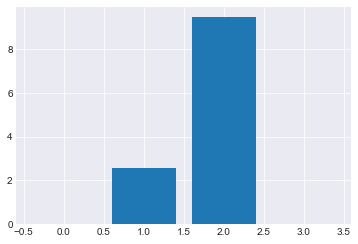

In [24]:
print(m.kern.variances.value)
plt.bar(range(num_levels+1), m.kern.variances.value)

We plot the inverse lengthscales, that is, the relevance of each stream dimension. Seems like adding time as the first coordinate was an important step, which was given a high relevance, with all three other coordinates being weighted equally important.

[0.68127749 0.28732576 0.22343057 0.25516929]


<BarContainer object of 4 artists>

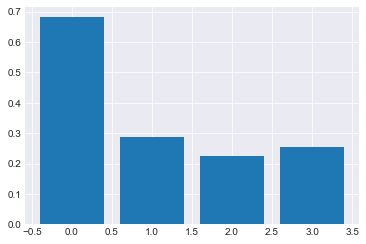

In [25]:
print(m.kern.gamma.value**0.5 * 1.0 / m.kern.lengthscales.value)
plt.bar(range(num_features), m.kern.gamma.value**0.5 * 1.0 / m.kern.lengthscales.value)

***
Now, we extract the convergence results from the optimization results.

In [43]:
time = [x['time'] for x in det.values()]
elbo = [x['elbo'] for x in det.values()]
val = [x['val'] for x in det.values()]

And apply a moving average of window 5 for a smoother convergence plot

In [44]:
elbo = [np.mean(elbo[np.maximum(i-4, 0):i+1]) for i in range(len(det.values()))]
val = [np.mean(val[np.maximum(i-4, 0):i+1]) for i in range(len(det.values()))]

Text(0.5, 1.0, 'Convergence')

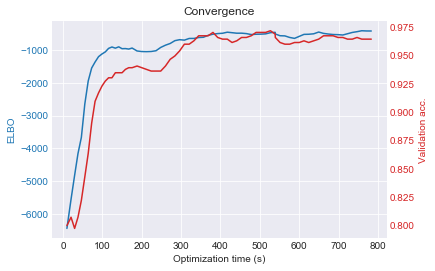

In [45]:
fig, ax = plt.subplots()
ln = ax.plot(time, elbo, color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.set_ylabel('ELBO', color='tab:blue')
ax.set_xlabel('Optimization time (s)')
ax2 = ax.twinx()
ln2 = ax2.plot(time, val, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.grid(False)
ax2.set_ylabel('Validation acc.', color='tab:red')
ax.set_title('Convergence')

***
And finally, we compute predictions on the test set, and inspect the results of the classification report:

In [47]:
pred_batch_size = 100
num_batches = int(np.ceil(num_test/pred_batch_size))
y_test_pred = np.zeros((num_test, ))
for i in range(num_batches):
    print('\r{}/{}'.format(i+1, num_batches), end='')
    lo = i * pred_batch_size
    hi = np.minimum(num_test, (i+1) * pred_batch_size)
    pred = m.predict_y(X_test[lo:hi])[0]
    y_test_pred[lo:hi] = np.argmax(pred, axis=1).flatten()

36/36

In [48]:
from sklearn.metrics import classification_report
print('Accuracy on test set: {}'.format(accuracy_score(y_test, y_test_pred)))
print('Classification report:')
print(classification_report(y_test, y_test_pred))

Accuracy on test set: 0.9547738693467337
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       437
           1       0.99      0.99      0.99       452
           2       0.97      0.94      0.96       454
           3       0.96      0.90      0.93       450
           4       0.87      0.96      0.91       433
           5       0.93      0.90      0.92       449
           6       0.98      1.00      0.99       447
           7       0.99      0.98      0.98       460

    accuracy                           0.95      3582
   macro avg       0.96      0.95      0.95      3582
weighted avg       0.96      0.95      0.95      3582

